In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import os, random
path = '/home/nonsodono/Documents/face_images'
os.chdir(path)  

In [13]:
#hide
!pip3 install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [14]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
    )

In [15]:
dls = faces.dataloaders(path)

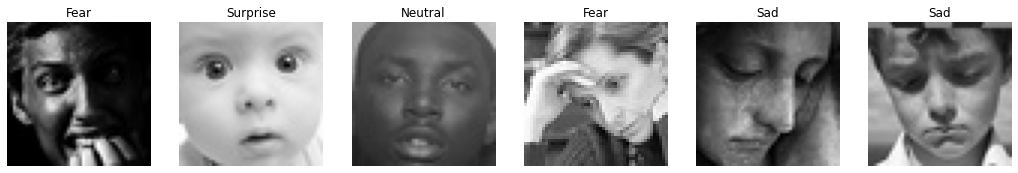

In [16]:
dls.train.show_batch(max_n=6, nrows=1)

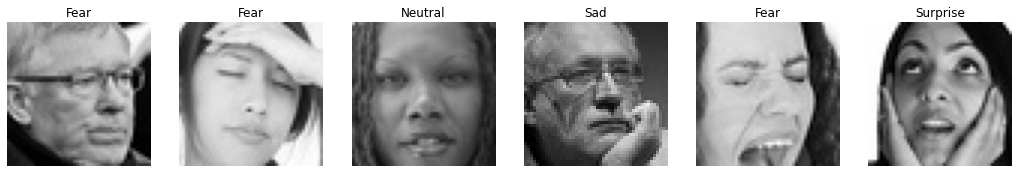

In [17]:
dls.valid.show_batch(max_n=6, nrows=1)

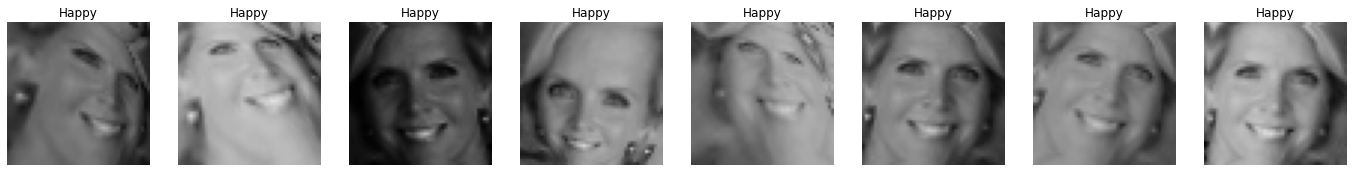

In [18]:
faces = faces.new(item_tfms=Resize(48), batch_tfms=aug_transforms(mult=2))
dls = faces.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

In [19]:
model = cnn_learner(dls, vgg19_bn, metrics=accuracy)
model.fine_tune(6)

epoch,train_loss,valid_loss,accuracy,time
0,2.064974,1.745133,0.340877,00:35


epoch,train_loss,valid_loss,accuracy,time
0,1.553493,1.351746,0.492632,00:49
1,1.310051,1.192109,0.561579,00:49
2,1.211429,1.072403,0.595789,00:50
3,1.135439,1.016679,0.624035,00:49
4,1.034092,0.973535,0.641754,00:49
5,1.003430,0.975245,0.640175,00:50


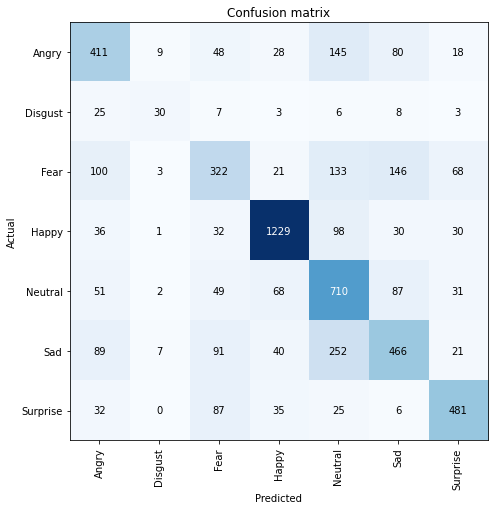

In [20]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(7,7))

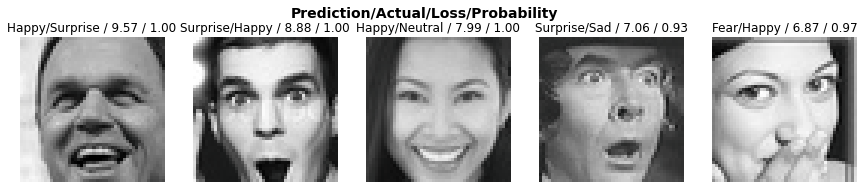

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), str(path/cat).split('.')[0] + "_fixed.jpg")

In [24]:
model.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
model_inf = load_learner(path/'export.pkl')

In [27]:
model_inf.dls.vocab

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

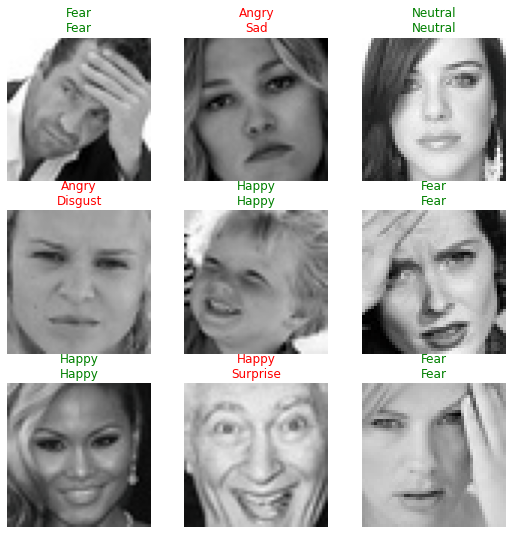

In [28]:
model.show_results()

In [29]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [30]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your face!'), 
      btn_upload, btn_run, out_pl, lbl_pred])